In [2]:
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='paper')
import numpy as np
from util import color_list,hatch_list,linestyle_list,markertype_list
from collections import defaultdict

In [3]:
def pn_distance(a, b, p):
    x = a.quantile(p)
    y = b.quantile(p)
    return (y - x) / x
    
def p99_distance(a, b):
    return pn_distance(a, b, 0.99)

P99_PERCENTILE_LIST = np.arange(1, 101, 1)

MTU=1000
BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=5BDP', 3:'5BDP<size'}

n_size_bucket_list_output=len(bin_size_list)+1
n_percentiles=len(P99_PERCENTILE_LIST)

file2matrix = {
    '../../workload/spatials/cluster_a_2_16.json': 'Matrix A',
    '../../workload/spatials/cluster_b_2_16.json': 'Matrix B',
    '../../workload/spatials/cluster_c_2_16.json': 'Matrix C',
}
file2dist = {
    '../../workload/distributions/facebook/webserver-all.txt': 'WebServer',
    '../../workload/distributions/facebook/hadoop-all.txt': 'Hadoop',
    '../../workload/distributions/facebook/cachefollower-all.txt': 'CacheFollower',
}
file2oversub = {
    'spec/cluster_1_to_1.json': '1-to-1',
    'spec/cluster_2_to_1.json': '2-to-1',
    'spec/cluster_4_to_1.json': '4-to-1',
}

In [37]:
mlsys_dir='mlsys_final_reprod_v1'
N_FLOW_THRESHOLD=10
NR_PATHS_SAMPLED=500
NR_INTEPOLATE=100
N_FLOWS=NR_PATHS_SAMPLED*NR_INTEPOLATE*4
def create_record(mix):
    mix_id = mix['id']
    mix_dir = f'../data/{mix_id}'
    
    # Load info
    with open(f'{mix_dir}/pmn-m/loads.json') as f:
        loads = json.load(f)
        loads.sort(reverse=True)
    loads = pd.DataFrame(loads, columns=['load'])
    max_load = loads['load'][0]
    idx = int(len(loads) * 0.1)
    top10pct_load = loads['load'][:idx].mean()

    assert (os.path.exists(f'../data/{mix["id"]}/{mlsys_dir}/elapsed.txt'))
    
    df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
    df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
    sizes=df_pmn_m['size']
    # Accuracy metrics
    df_mlsys = []
    df_mlsys_per_bucket = [[] for _ in range(n_size_bucket_list_output)]
    n_freq_list=[]
    n_flow_list=[]
    path_idx=0
    while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
        with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
            lines = file.readlines()
            data=lines[0].strip().split(",")
            n_freq=int(data[-1])
            n_freq_list.append(n_freq)
            
            flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
            size_list=[sizes[flowid] for flowid in flowid_list]
            
            tmp=np.digitize(size_list, bin_size_list)
            # Count occurrences of each bin index
            bin_counts = np.zeros(n_size_bucket_list_output)
            for bin_idx in tmp:
                bin_counts[bin_idx]+=1
            n_flow_list.append(bin_counts)
        path_idx+=1
    
    n_flow_list=np.array(n_flow_list)
    n_flow_list_sum=n_flow_list.sum(axis=0)
    bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
    
    with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
        lines = file.readlines()
    lines = lines[1:]
    for line_idx,line in enumerate(lines):
        data=line.strip().split(",")
        data = [float(value) for value in data]
        n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
        
        if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD:
            for _ in range(n_freq):
                df_mlsys_per_bucket[line_idx%n_size_bucket_list_output].extend(data)
        
    for i in range(len(df_mlsys_per_bucket)):
        n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
        df_mlsys.extend(np.random.choice(df_mlsys_per_bucket[i],n_tmp,replace=True))
    
    df_mlsys=pd.DataFrame(np.array(df_mlsys).flatten())
    
    
    print(f"{mix_id}: len=",df_ns3.shape[0],df_pmn_m.shape[0],len(df_mlsys[0]))
    
    # was__ns3__pmn_m = wasserstein_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    p99__ns3__pmn_m = p99_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    # was__ns3__mlsys = wasserstein_distance(df_ns3['slowdown'], df_mlsys)
    p99__ns3__mlsys = p99_distance(df_ns3['slowdown'], df_mlsys[0])

    print(p99__ns3__pmn_m,p99__ns3__mlsys)
    record = {
        'id': mix['id'],
        'matrix': file2matrix[mix['spatial']],
        'size_dist': file2dist[mix['size_dist']],
        'lognorm_sigma': mix['lognorm_sigma'],
        'max_load_spec': mix['max_load'],
        'max_load': max_load,
        'top10pct_load': top10pct_load,
        'oversub': file2oversub[mix['cluster']],
        # 'was__ns3__pmn_m': was__ns3__pmn_m,
        'p99__ns3__pmn_m': p99__ns3__pmn_m,
        # 'was__ns3__mlsys': was__ns3__mlsys,
        'p99__ns3__mlsys': p99__ns3__mlsys,
    }
    return record
    
def get_records():
    mix_file = '../spec/all.mix.json'
    csv_file = 'main_sensitivity.csv'
    if os.path.exists(csv_file):
        mixes = pd.read_csv(csv_file)
    else:
        with open(mix_file) as f:
            mixes = json.load(f) 
        mixes = pd.DataFrame(list(map(create_record, mixes)))
        mixes.to_csv(csv_file, index=False)
    return mixes

records = get_records()
print(records.shape)

(192, 10)


In [38]:
time_elapsed=defaultdict(lambda:[])
time_elapsed_2=defaultdict(lambda:[])
# method_list=['ns3','pmn-m','mlsys_s2_bt50','mlsys_s2_bt50_2k']
method_list=['ns3','pmn-m','mlsys_final_reprod_v1']
root_dir_baseline="/data1/lichenni/projects/flow_simulation/parsimon-eval/expts/fig_8/data"
root_dir_mlsys=root_dir_baseline
time_preprop=defaultdict(lambda:[])
time_path_sim=defaultdict(lambda:[])
for mix_id in range(192):
    for method in method_list:
        if not method.startswith('mlsys'):
            root_dir=root_dir_baseline
            with open(f'{root_dir}/{mix_id}/{method}/elapsed.txt') as file:
                for line in file:
                    tmp=line.rstrip()
                    time_elapsed[method].append(int(tmp))
        else:
            root_dir=root_dir_mlsys
            if os.path.exists(f'{root_dir}/{mix_id}/{method}/elapsed.txt'):
                with open(f'{root_dir}/{mix_id}/{method}/elapsed.txt') as file:
                    for line in file:
                        tmp=line.rstrip().split(',')
                        time_elapsed[method].append(int(tmp[0])-int(tmp[2]))
                        time_elapsed_2[method].append(int(tmp[1]))
            path_id=0
            while os.path.exists(f'{root_dir}/{mix_id}/{method}/path_{path_id}.txt'):
                with open(f'{root_dir}/{mix_id}/{method}/path_{path_id}.txt') as file:
                    for line_id,line in enumerate(file):
                        if line_id==1:
                            tmp=line.rstrip().split(',')
                            time_preprop[method].append(int(tmp[0]))
                            time_path_sim[method].append(int(tmp[1]))
                path_id+=1
            
print([f"{key}: {np.min(time_elapsed[key])},{np.median(time_elapsed[key])},{np.max(time_elapsed[key])}" for key in time_elapsed])
# legend_list=["{}:{:.0f}s, {:.0f}s, {:.0f}s".format(key,np.min(time_elapsed[key]),np.median(time_elapsed[key]),np.max(time_elapsed[key])) for key in time_elapsed]
legend_list=['ns3','pmn-m','mlsys_1k paths','mlsys_2k (time-1)']
res=np.array(list(time_elapsed.values()))
print(res.shape)
records['ns3_time']=res[0]
records['pmn-m_time']=res[1]
records['mlsys_time']=res[2]-4

['ns3: 16448,116134.5,204264', 'pmn-m: 36,167.5,378', 'mlsys_final_reprod_v1: 21,46.5,82']
(3, 192)


## Max load

### CDFs

In [39]:
def ecdfplot(df, x):
    df['pct'] = df.groupby(by=['kind'], as_index=False)[x].rank(pct=True)
    plt.figure(figsize=(4, 1.5))
    ax = sns.lineplot(data=df, x=x, y='pct', hue='kind', style='kind', ci=None)
    ax.get_legend().set_title('Max load (top 10% avg)')
    ax.get_legend().set_frame_on(False)
    sns.despine()
    plt.ylabel('CDF')
    
def percentify(x):
    return f'{int(round(x, 2) * 100)}%'


In [7]:
print(records['max_load'].min())
print(records['max_load'].max())

0.2602780435058261
0.7748544133669228


In [5]:
worst_low_id=records['p99__ns3__mlsys'].idxmin()
worst_low_p99=records['p99__ns3__mlsys'].min()
worst_high_id=records['p99__ns3__mlsys'].idxmax()
worst_high_p99=records['p99__ns3__mlsys'].max()
print("{}:{}, {}:{}".format(worst_low_id, worst_low_p99, worst_high_id, worst_high_p99))
print(records[records['id']==worst_low_id])
print(records[records['id']==worst_high_id])

53:-0.1641504675773217, 30:0.2278941295275291
    id    matrix      size_dist  lognorm_sigma  max_load_spec  max_load  \
53  53  Matrix C  CacheFollower            2.0       0.739021  0.744086   

    top10pct_load oversub  p99__ns3__pmn_m  p99__ns3__mlsys  
53       0.307399  1-to-1         0.109277         -0.16415  
    id    matrix  size_dist  lognorm_sigma  max_load_spec  max_load  \
30  30  Matrix C  WebServer            2.0       0.262553  0.273809   

    top10pct_load oversub  p99__ns3__pmn_m  p99__ns3__mlsys  
30       0.131104  4-to-1         0.038431         0.227894  


median: 0.043415099804262,0.05978415660828605
 90%: 0.10148530785792054,0.12289079852246963
 max: 0.2278941295275291,0.4871533897306813


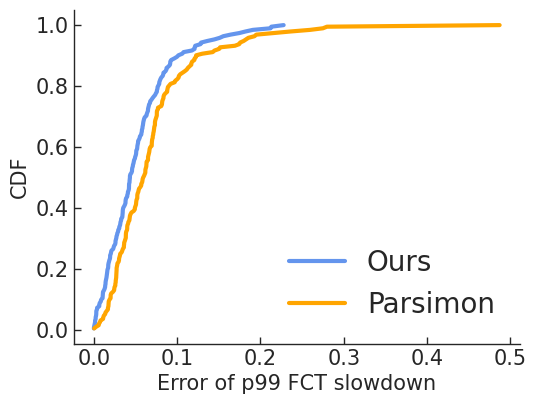

In [100]:
_fontsize=15
records_abs=records.copy()
records_abs['p99__ns3__mlsys']=abs(records_abs['p99__ns3__mlsys'])
records_abs['p99__ns3__pmn_m']=abs(records_abs['p99__ns3__pmn_m'])
column_list=['p99__ns3__mlsys','p99__ns3__pmn_m']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 4.0), sharex=True)
ax.tick_params(axis="y", direction="in")
ax.tick_params(axis="x", direction="in")

for i,each in enumerate(column_list):
    data=records_abs
    data['pct'] = data[each].rank(pct=True)
    ax=sns.lineplot(data = data, x = each, y = 'pct', color = color_list[i], errorbar=None, ax=ax,linewidth=3,)
    
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()
labels=['Ours','Parsimon']
# XXX: This is a dirty hack. Look carefully at the labels!
plt.legend(labels=labels, loc='lower right', frameon=False, ncol=1,prop={"size": _fontsize+5})
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown', fontsize=_fontsize)
plt.ylabel('CDF', fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)
# plt.xlim(1.0)
plt.savefig('figs/sensitivity_cdf.pdf', bbox_inches='tight',pad_inches=0)
print(f"median: {np.median(records_abs['p99__ns3__mlsys'])},{np.median(records_abs['p99__ns3__pmn_m'])}\n 90%: {np.percentile(records_abs['p99__ns3__mlsys'], 90)},{np.percentile(records_abs['p99__ns3__pmn_m'], 90)}\n max: {np.max(records_abs['p99__ns3__mlsys'])},{np.max(records_abs['p99__ns3__pmn_m'])}")

['mlsys_time: 42.5, 65.0, 78 ', 'pmn-m_time: 167.5, 319.9, 378 ', 'ns3_time: 116134.5, 179876.6, 204264 ']


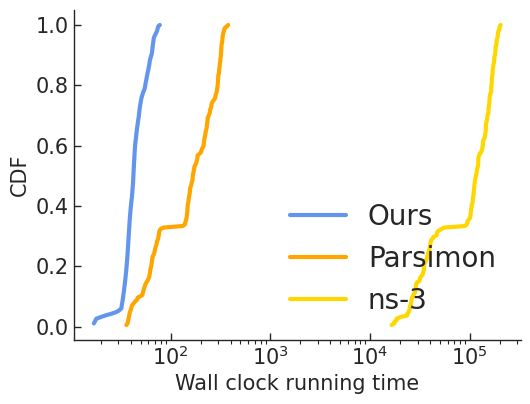

In [105]:
_fontsize=15
column_list=['mlsys_time','pmn-m_time','ns3_time']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 4.0), sharex=True)
ax.tick_params(axis="y", direction="in")
ax.tick_params(axis="x", direction="in")

for i,each in enumerate(column_list):
    data=records
    data['pct'] = data[each].rank(pct=True)
    ax=sns.lineplot(data = data, x = each, y = 'pct', color = color_list[i], errorbar=None, ax=ax,linewidth=3,)
    
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()
labels=['Ours','Parsimon', 'ns-3']
# XXX: This is a dirty hack. Look carefully at the labels!
plt.legend(labels=labels, loc='lower right', frameon=False, ncol=1,prop={"size": _fontsize+5})
plt.xscale('log')
sns.despine()
fig.tight_layout()
plt.xlabel('Wall clock running time', fontsize=_fontsize)
plt.ylabel('CDF', fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)
# plt.xlim(1.0)
plt.savefig('figs/sensitivity_cdf_time.pdf', bbox_inches='tight',pad_inches=0)
print([f"{each}: {np.median(records[each])}, {np.percentile(records[each], 90)}, {np.max(records[each])} " for each in column_list])

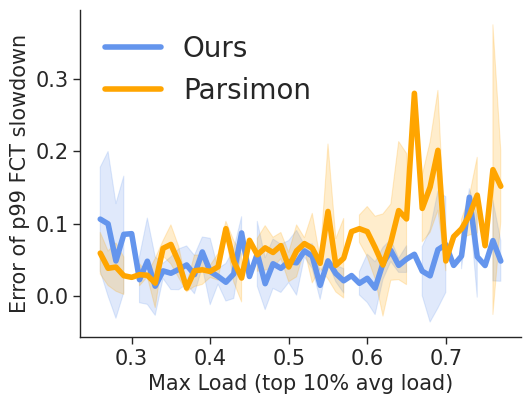

In [6]:
_fontsize=15
records_abs=records.copy()
records_abs['p99__ns3__mlsys']=abs(records_abs['p99__ns3__mlsys'])
records_abs['p99__ns3__pmn_m']=abs(records_abs['p99__ns3__pmn_m'])

records_abs['max_load']=records_abs['max_load']//0.01*0.01

records_abs=records_abs.sort_values(by='max_load')
column_list=['p99__ns3__mlsys','p99__ns3__pmn_m']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 4.0), sharex=True)
labels=['Ours','Parsimon']
for i,each in enumerate(column_list):
    # ax=sns.scatterplot(data = records_abs, x = 'max_load', y = each, color = color_list[i], ax=axs, marker=markertype_list[i], s=30)
    # ax = sns.lineplot(data=records_abs, x='max_load', y=each, color=color_list[i], ax=axs, marker=markertype_list[i], label=each, ci='sd')
    # ax=sns.lineplot(data=records_abs, x='max_load', y=each, color=color_list[i], ax=axs, marker=markertype_list[i], label=each, ci=None, estimator='mean', lw=2)
    # sns.scatterplot(x='max_load', y=each, data=records_abs, color=color_list[i], ax=axs, label=f'{each} Raw', s=30)
    sns.lineplot(x='max_load', y=each, data=records_abs, color=color_list[i], ax=axs, label=labels[i], errorbar='sd', estimator='median', lw=4)
    
    # print(f"{each}: ",records_abs[each].min(),records_abs[each].max())
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()

# XXX: This is a dirty hack. Look carefully at the labels!
# fig.legend(loc='upper right', frameon=False, ncol=1)
plt.legend(loc='upper left', frameon=False, ncol=1,prop={"size": _fontsize+5})
sns.despine()
fig.tight_layout()
plt.xlabel('Max Load (top 10% avg load)',fontsize=_fontsize)
plt.ylabel('Error of p99 FCT slowdown',fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)
plt.savefig('figs/sensitivity_error_over_load.pdf', bbox_inches='tight')

0.7748544133669228
0.75


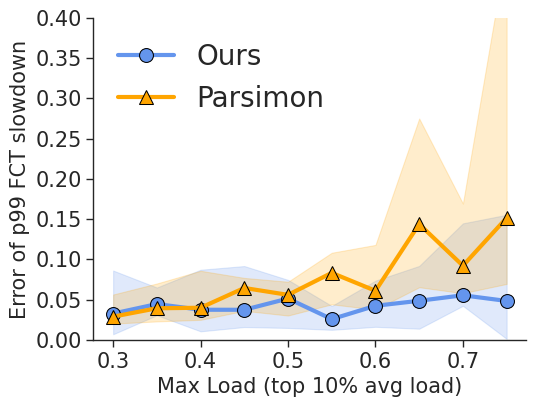

In [49]:
_fontsize=15
records_abs=records.copy()
records_abs['p99__ns3__mlsys']=abs(records_abs['p99__ns3__mlsys'])
records_abs['p99__ns3__pmn_m']=abs(records_abs['p99__ns3__pmn_m'])

# records_abs.loc[records_abs['max_load'] < 0.3, 'max_load'] = 0.3
print(max(records_abs['max_load']))
records_abs['max_load']=records_abs['max_load']//0.05*0.05
print(max(records_abs['max_load']))
records_abs=records_abs[records_abs['max_load']>=0.3]

records_abs=records_abs.sort_values(by='max_load')
column_list=['p99__ns3__mlsys','p99__ns3__pmn_m']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 4.0), sharex=True)
labels=['Ours','Parsimon']
for i,each in enumerate(column_list):
    # ax=sns.scatterplot(data = records_abs, x = 'max_load', y = each, color = color_list[i], ax=axs, marker=markertype_list[i], s=30)
    ax = sns.lineplot(data=records_abs, x='max_load', y=each, color=color_list[i], ax=axs, marker=markertype_list[i], label=labels[i], errorbar=("ci", 100), estimator='median', lw=3,markeredgecolor='black',markersize=10)
    # ax=sns.lineplot(data=records_abs, x='max_load', y=each, color=color_list[i], ax=axs, marker=markertype_list[i], label=each, ci=None, estimator='mean', lw=2)
    # sns.scatterplot(x='max_load', y=each, data=records_abs, color=color_list[i], ax=axs, label=f'{each} Raw', s=30)
    
    # print(f"{each}: ",records_abs[each].min(),records_abs[each].max())
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()

# XXX: This is a dirty hack. Look carefully at the labels!
# fig.legend(loc='upper right', frameon=False, ncol=1)
plt.ylim(0,0.4)
plt.legend(loc='upper left', frameon=False, ncol=1,prop={"size": _fontsize+5})
sns.despine()
fig.tight_layout()
plt.xlabel('Max Load (top 10% avg load)',fontsize=_fontsize)
plt.ylabel('Error of p99 FCT slowdown',fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)

plt.savefig('figs/sensitivity_error_over_load.pdf', bbox_inches='tight')

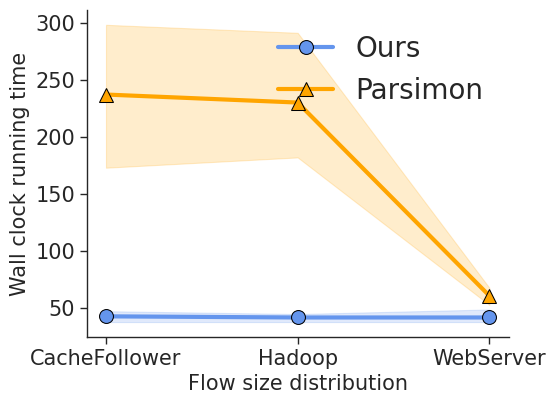

In [106]:
_fontsize=15
records_time=records.copy()

records_time['max_load']=records_time['max_load']//0.08*0.08
key_x='size_dist'
records_time=records_time.sort_values(by=key_x)
column_list=['mlsys_time','pmn-m_time']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 4.0), sharex=True)
labels=['Ours','Parsimon',"ns-3"]
for i,each in enumerate(column_list):
    
    ax = sns.lineplot(data=records_time, x=key_x, y=each, color=color_list[i], ax=axs, marker=markertype_list[i], label=labels[i], errorbar=("ci", 100), estimator='median', lw=3,markeredgecolor='black',markersize=10)
    
# XXX: This is a dirty hack. Look carefully at the labels!
# fig.legend(loc='upper right', frameon=False, ncol=1)
plt.legend(loc='upper right', frameon=False, ncol=1,prop={"size": _fontsize+5})
# plt.yscale('log')
sns.despine()
fig.tight_layout()
plt.xlabel('Flow size distribution',fontsize=_fontsize)
plt.ylabel('Wall clock running time',fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)
plt.savefig('figs/sensitivity_time_over_load.pdf', bbox_inches='tight')

In [8]:
records = records.sort_values(by='max_load')
n = round(len(records) / 2)
records_l = records.iloc[0:n].copy()
records_h = records.iloc[n:].copy()

# records_l = records[records['max_load'] <= 0.5].copy()
# records_m = records[records['max_load'] <= 0.65].copy()
# records_h = records[records['max_load'] <= 1.0].copy()
max_load = records['max_load'].max()

max_load_l_min = records_l['max_load'].min()
max_load_h_min = records_h['max_load'].min()

max_load_l_max = records_l['max_load'].max()
max_load_h_max = records_h['max_load'].max()

top10pct_load_l_min = records_l['top10pct_load'].min()
top10pct_load_h_min = records_h['top10pct_load'].min()

top10pct_load_l_max = records_l['top10pct_load'].max()
top10pct_load_h_max = records_h['top10pct_load'].max()

records_l.loc[:, 'kind'] = 'low'
records_h.loc[:, 'kind'] = 'high'
records.loc[:, 'kind'] = 'all'
records_lmh = pd.concat([records_l, records_h,records], ignore_index=True)
# x_lim_range=(-1.0, 1.0)

In [9]:
# records_lmh['p99__ns3__ns3_path'] = records_lmh['p99__ns3__ns3_path'].abs()
records_lmh['p99__ns3__mlsys'] = records_lmh['p99__ns3__mlsys'].abs()
records_lmh['p99__ns3__pmn_m'] = records_lmh['p99__ns3__pmn_m'].abs()
# x_lim_range=(0, 1.0)

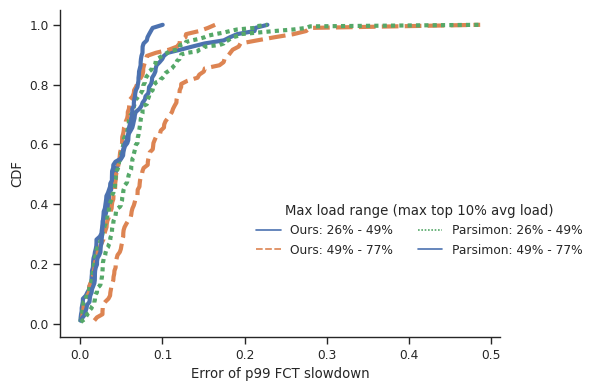

In [10]:
target_method_list=['p99__ns3__mlsys','p99__ns3__pmn_m']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 4.0), sharex=True)
for i,target_method in enumerate(target_method_list):
    records_lmh['pct'] = records_lmh.groupby(by=['kind'], as_index=False)[target_method].rank(pct=True)
    ax = sns.lineplot(data=records_lmh, x=target_method, y='pct', hue='kind', style='kind', errorbar=None,color=color_list[i], linewidth=3)

handles = ax.get_legend().get_lines()
ax.get_legend().remove()
title='Max load range (max top 10% avg load)'
labels=[
    f'Ours: {percentify(max_load_l_min)} - {percentify(max_load_l_max)}',
    f'Ours: {percentify(max_load_h_min)} - {percentify(max_load_h_max)}',
    f'Parsimon: {percentify(max_load_l_min)} - {percentify(max_load_l_max)}',
    f'Parsimon: {percentify(max_load_h_min)} - {percentify(max_load_h_max)}',
]
# XXX: This is a dirty hack. Look carefully at the labels!
fig.legend(handles=handles, labels=labels, title=title, loc='lower right', frameon=False, ncol=2, bbox_to_anchor=(1.15, 0.32))
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown')
plt.ylabel('CDF')
plt.savefig('figs/error-dist-0.pdf', bbox_inches='tight')

## Everything else (fix moderate load)

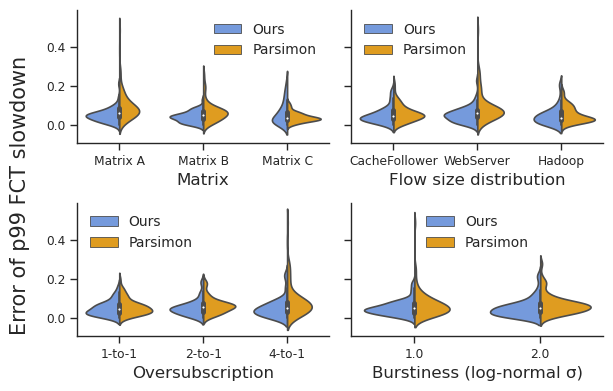

In [40]:
def violins(df):
    xs_labels_orders_rot = [
        ('matrix', 'Matrix', ['Matrix A', 'Matrix B', 'Matrix C'], 0),
        ('oversub', 'Oversubscription', ['1-to-1', '2-to-1', '4-to-1'], 0),
        ('size_dist', 'Flow size distribution', ['CacheFollower', 'WebServer', 'Hadoop'], 0),
        ('lognorm_sigma', 'Burstiness (log-normal σ)', [1.0, 2.0], 0),
    ]
    legend_loc_list=['upper right','upper left','upper left','upper center']
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6.2, 4.), sharey=True)

    for i, (x, label, order, rot) in enumerate(xs_labels_orders_rot):
        j, k = i % 2, int(i / 2)

        # Create a list of colors for each violin
        # colors = [f'C{i}' for i in range(len(df['kind'].unique()))]

        ax = sns.violinplot(
            data=df[df[x].isin(order)],
            x=x,
            y='error',
            hue='kind',
            order=order,
            ax=axs[j, k],
            split=True,
            palette=color_list,
        )
        ax.set_xlabel(label,fontsize=12)
        for tick in ax.get_xticklabels():
            tick.set_rotation(rot)
        ax.set_ylabel('')
    # Remove "kind" from the legend
    for idx,ax in enumerate(axs.flat):
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[0:], labels=labels[0:],frameon=False,loc=legend_loc_list[idx],prop={"size": 10})
    sns.despine()
    fig.supylabel('Error of p99 FCT slowdown',fontsize=15)
    fig.tight_layout()

# Assuming records and 'kind' column are defined somewhere in your script
df_violin_pmn = records.copy()
df_violin_mlsys = records.copy()
df_violin_pmn['kind'] = 'Parsimon'
df_violin_pmn['error'] = abs(df_violin_pmn["p99__ns3__pmn_m"])
df_violin_mlsys['kind'] = 'Ours' 
df_violin_mlsys['error'] = abs(df_violin_mlsys["p99__ns3__mlsys"])
df_violin = pd.concat([df_violin_mlsys,df_violin_pmn], ignore_index=True)

violins(df_violin)
plt.savefig('figs/sensitivity_violin.pdf', bbox_inches='tight')


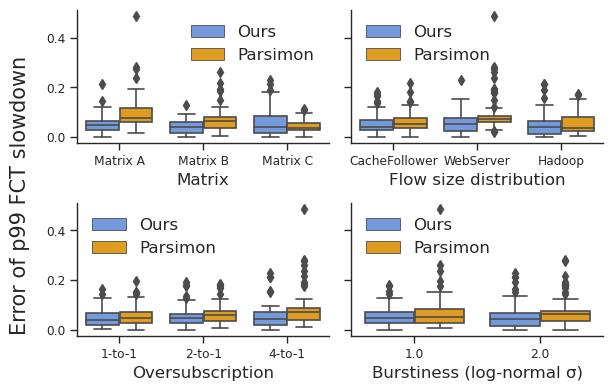

In [46]:
def violins(df):
    xs_labels_orders_rot = [
        ('matrix', 'Matrix', ['Matrix A', 'Matrix B', 'Matrix C'], 0),
        ('oversub', 'Oversubscription', ['1-to-1', '2-to-1', '4-to-1'], 0),
        ('size_dist', 'Flow size distribution', ['CacheFollower', 'WebServer', 'Hadoop'], 0),
        ('lognorm_sigma', 'Burstiness (log-normal σ)', [1.0, 2.0], 0),
    ]
    legend_loc_list=['upper right','upper left','upper left','upper left']
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6.2, 4.), sharey=True)

    for i, (x, label, order, rot) in enumerate(xs_labels_orders_rot):
        j, k = i % 2, int(i / 2)

        # Create a list of colors for each violin
        # colors = [f'C{i}' for i in range(len(df['kind'].unique()))]
        ax = sns.boxplot(
            data=df[df[x].isin(order)],
            x=x,
            y='error',
            hue='kind',
            order=order,
            ax=axs[j, k],
            palette=color_list,
        )
        ax.set_xlabel(label,fontsize=12)
        for tick in ax.get_xticklabels():
            tick.set_rotation(rot)
        ax.set_ylabel('')
    # Remove "kind" from the legend
    for idx,ax in enumerate(axs.flat):
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[0:], labels=labels[0:],frameon=False,loc=legend_loc_list[idx],prop={"size": 12})
    sns.despine()
    fig.supylabel('Error of p99 FCT slowdown',fontsize=15)
    fig.tight_layout()

# Assuming records and 'kind' column are defined somewhere in your script
df_violin_pmn = records.copy()
df_violin_mlsys = records.copy()
df_violin_pmn['kind'] = 'Parsimon'
df_violin_pmn['error'] = abs(df_violin_pmn["p99__ns3__pmn_m"])
df_violin_mlsys['kind'] = 'Ours' 
df_violin_mlsys['error'] = abs(df_violin_mlsys["p99__ns3__mlsys"])
df_violin = pd.concat([df_violin_mlsys,df_violin_pmn], ignore_index=True)

violins(df_violin)
plt.savefig('figs/sensitivity_boxplot.pdf', bbox_inches='tight')


In [31]:
mlsys_dir="mlsys-param_e267_p500_l100_t1"
save_file=f'./gen_{mlsys_dir}_nosamp.npz'
data=np.load(save_file)
tmp=data['res_final']
n_flows_in_f_list_final=data['n_flows_in_f_list_final']
error_abs=np.abs((tmp[:,:,1]-tmp[:,:,0])/tmp[:,:,0])

mix_file = '../spec/mlsys.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 
mix_file = '../spec/mlsys_param.mix.json'
with open(mix_file) as f:
    mixes_param = json.load(f) 
assert len(mixes)==len(mixes_param)

res_cc=[]
for mix_id in range(len(mixes)):
    mix=mixes[mix_id]
    mix_param=mixes_param[mix_id]
    cc=str(mix_param['cc'])
    load=float(mix['max_load'])
    
    if cc!='dctcp':
        tmp=[load,cc]
        tmp.extend(error_abs[mix_id])
        res_cc.append(tmp)
    
mlsys_dir="mlsys_e267_p500_l100_t1"
save_file=f'./gen_{mlsys_dir}_nosamp.npz'
# save_file=f'./gen_mlsys_0129/gen_mlsys_final_reprod_v1_p500_l100_t10_nosamp.npz'
data=np.load(save_file)
tmp=data['res_final']
n_flows_in_f_list_final=data['n_flows_in_f_list_final']
error_abs=np.abs((tmp[:,:,2]-tmp[:,:,0])/tmp[:,:,0])

mix_file = '../spec/all.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 
for mix_id in range(len(mixes)):
    mix=mixes[mix_id]
    load=float(mix['max_load'])
    tmp=[load,'dctcp']
    tmp.extend(error_abs[mix_id])
    res_cc.append(tmp)
res_cc=np.array(res_cc)
print("res_cc:", res_cc.shape)
   
column_names = ['max_load', 'cc', 'error_0',"error_1","error_2","error_3","error_4"]
data_frame_cc = pd.DataFrame(res_cc, columns=column_names)

print(data_frame_cc.shape)
data_frame_cc['max_load']=data_frame_cc['max_load'].astype(float)
data_frame_cc['cc']=data_frame_cc['cc'].astype(str)
data_frame_cc['error_0']=data_frame_cc['error_0'].astype(float)
data_frame_cc['error_1']=data_frame_cc['error_1'].astype(float)
data_frame_cc['error_2']=data_frame_cc['error_2'].astype(float)
data_frame_cc['error_3']=data_frame_cc['error_3'].astype(float)
data_frame_cc['error_4']=data_frame_cc['error_4'].astype(float)


res_cc: (265, 7)
(265, 7)


In [32]:
# cc figures
data_frame_cc_low=data_frame_cc[data_frame_cc['max_load']<0.40]
data_frame_cc_mid=data_frame_cc[(data_frame_cc['max_load'] >= 0.40) & (data_frame_cc['max_load'] < 0.60)]
data_frame_cc_high=data_frame_cc[data_frame_cc['max_load']>=0.60]
print(data_frame_cc_low.shape,data_frame_cc_mid.shape,data_frame_cc_high.shape)

for data_cc in [data_frame_cc_low,data_frame_cc_mid,data_frame_cc_high]:
    print("\n")
    for cc in ['dctcp','timely','dcqcn']:
        data_cc_tmp=data_cc[data_cc['cc']==cc]
        # print(f"{cc}: {np.median(data_cc_tmp['error_0'])},{np.median(data_cc_tmp['error_1'])},{np.median(data_cc_tmp['error_2'])},{np.median(data_cc_tmp['error_3'])},{np.median(data_cc_tmp['error_4'])}")
        print("{}: {:.1f}%,{:.1f}%,{:.1f}%,{:.1f}%,{:.1f}%".format(cc,np.median(data_cc_tmp['error_0']*100),np.median(data_cc_tmp['error_1']*100),np.median(data_cc_tmp['error_2']*100),np.median(data_cc_tmp['error_3']*100),np.median(data_cc_tmp['error_4']*100)))

(107, 7) (98, 7) (60, 7)


dctcp: 6.8%,7.4%,7.0%,4.5%,13.9%
timely: 6.3%,5.9%,2.7%,12.0%,18.7%
dcqcn: 6.8%,8.2%,6.2%,11.5%,7.6%


dctcp: 6.1%,5.3%,5.1%,4.1%,14.6%
timely: 12.6%,11.0%,9.3%,14.2%,19.2%
dcqcn: 2.1%,7.6%,4.0%,8.0%,4.1%


dctcp: 5.8%,9.7%,3.3%,7.3%,13.1%
timely: 16.3%,16.8%,14.6%,9.1%,5.2%
dcqcn: 6.6%,13.6%,7.7%,5.3%,8.1%


dctcp: median: 0.06036002536798083
 90%: 0.1359818534562604
 max: 0.30065418682452405
dcqcn: median: 0.060972746575815875
 90%: 0.12002498766328897
 max: 0.3434387597515868
timely: median: 0.11874515511073923
 90%: 0.21278347430838213
 max: 0.25590906136861835


/tmp/ipykernel_1737635/60396103.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pct'] = data['error_0'].rank(pct=True)
/tmp/ipykernel_1737635/60396103.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pct'] = data['error_0'].rank(pct=True)
/tmp/ipykernel_1737635/60396103.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ]),
 [Text(-0.05, 0, '−0.05'),
  Text(0.0, 0, '0.00'),
  Text(0.05, 0, '0.05'),
  Text(0.10000000000000002, 0, '0.10'),
  Text(0.15000000000000002, 0, '0.15'),
  Text(0.2, 0, '0.20'),
  Text(0.25000000000000006, 0, '0.25'),
  Text(0.30000000000000004, 0, '0.30'),
  Text(0.35000000000000003, 0, '0.35'),
  Text(0.4, 0, '0.40')])

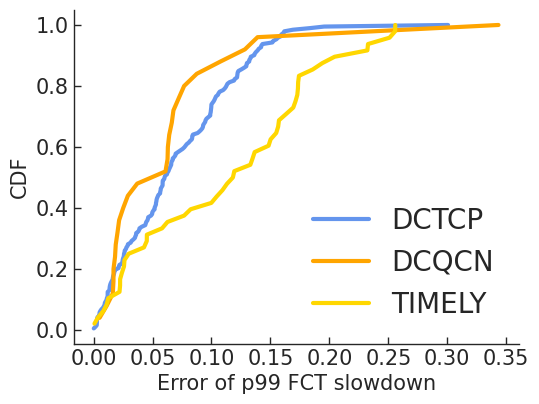

In [33]:
_fontsize=15
column_list=['dctcp','dcqcn','timely']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 4.0), sharex=True)
ax.tick_params(axis="y", direction="in")
ax.tick_params(axis="x", direction="in")

for i,each in enumerate(column_list):
    data=data_frame_cc[data_frame_cc['cc']==each]
    data['pct'] = data['error_0'].rank(pct=True)
    ax=sns.lineplot(data = data, x = 'error_0', y = 'pct', color = color_list[i], errorbar=None, ax=ax,linewidth=3,)
    
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()
    print(f"{each}: median: {np.median(data['error_0'])}\n 90%: {np.percentile(data['error_0'], 90)}\n max: {np.max(data['error_0'])}")
    
labels=['DCTCP','DCQCN','TIMELY']
# XXX: This is a dirty hack. Look carefully at the labels!
plt.legend(labels=labels, loc='lower right', frameon=False, ncol=1,prop={"size": _fontsize+5})
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown', fontsize=_fontsize)
plt.ylabel('CDF', fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)
# plt.xlim(1.0)
# plt.savefig('figs/sensitivity_cdf.pdf', bbox_inches='tight',pad_inches=0)


192


/tmp/ipykernel_1737635/3055233949.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['max_load']=data['max_load']//0.01*0.01


25
48


/tmp/ipykernel_1737635/3055233949.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['max_load']=data['max_load']//0.01*0.01
/tmp/ipykernel_1737635/3055233949.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['max_load']=data['max_load']//0.01*0.01


(array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 [Text(0.2, 0, '0.2'),
  Text(0.30000000000000004, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.7, 0, '0.7'),
  Text(0.8, 0, '0.8')])

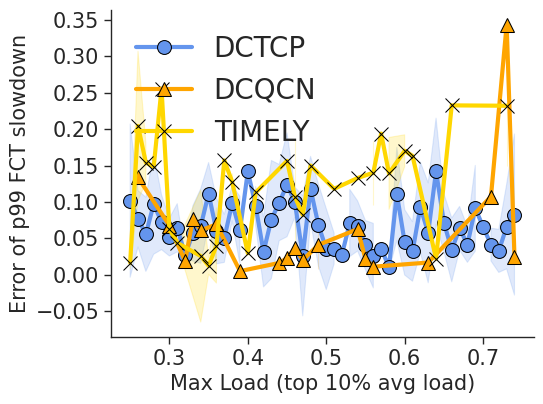

In [34]:
_fontsize=15

column_list=['dctcp','dcqcn','timely']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 4.0), sharex=True)
labels=['DCTCP','DCQCN','TIMELY']

for i,each in enumerate(column_list):
    data=data_frame_cc[data_frame_cc['cc']==each]
    print(len(data))
    data['max_load']=data['max_load']//0.01*0.01
    ax = sns.lineplot(data=data, x='max_load', y='error_0', color=color_list[i], ax=axs, marker=markertype_list[i], label=labels[i], errorbar='sd', estimator='median', lw=3,markeredgecolor='black',markersize=10)
   
# XXX: This is a dirty hack. Look carefully at the labels!
# fig.legend(loc='upper right', frameon=False, ncol=1)
plt.legend(loc='upper left', frameon=False, ncol=1,prop={"size": _fontsize+5})
sns.despine()
fig.tight_layout()
plt.xlabel('Max Load (top 10% avg load)',fontsize=_fontsize)
plt.ylabel('Error of p99 FCT slowdown',fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)
# plt.savefig('figs/sensitivity_error_over_load.pdf', bbox_inches='tight')

In [22]:
mlsys_dir="mlsys-param_e267_p500_l100_t5"
save_file=f'./gen_k_{mlsys_dir}_nosamp.npz'
data=np.load(save_file)
tmp=data['res_final']
n_flows_in_f_list_final=data['n_flows_in_f_list_final']
error_pmn=np.abs((tmp[:,:,1]-tmp[:,:,0])/tmp[:,:,0])
error_mlsys=np.abs((tmp[:,:,2]-tmp[:,:,0])/tmp[:,:,0])

mix_file = '../spec/pmn_m.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 
mix_file = '../spec/pmn_m_param.mix.json'
with open(mix_file) as f:
    mixes_param = json.load(f) 
assert len(mixes)==len(mixes_param)

res_k=[]
for mix_id in range(len(mixes)):
    mix=mixes[mix_id]
    mix_param=mixes_param[mix_id]
    
    cc=str(mix_param['cc'])
    load=float(mix['max_load'])
    window=int(mix_param['window'])
    if window==7000 or window==23000: continue
    
    tmp=[mix['id'],load,cc,str(window)+'pmn']
    tmp.extend(error_pmn[mix_id])
    res_k.append(tmp)
    
    tmp=[mix['id'],load,cc,str(window)+'mlsys']
    tmp.extend(error_mlsys[mix_id])
    res_k.append(tmp)
    
res_k=np.array(res_k)
print("res_k:", res_k.shape)
   
column_names = ['id','max_load', 'cc','method','error_0',"error_1","error_2","error_3","error_4"]
data_frame_k = pd.DataFrame(res_k, columns=column_names)

print(data_frame_k.shape)
data_frame_k['max_load']=data_frame_k['max_load'].astype(float)
# data_frame_k['window']=data_frame_k['window'].astype(int)
data_frame_k['cc']=data_frame_k['cc'].astype(str)
data_frame_k['method']=data_frame_k['method'].astype(str)
data_frame_k['error_0']=data_frame_k['error_0'].astype(float)
data_frame_k['error_1']=data_frame_k['error_1'].astype(float)
data_frame_k['error_2']=data_frame_k['error_2'].astype(float)
data_frame_k['error_3']=data_frame_k['error_3'].astype(float)
data_frame_k['error_4']=data_frame_k['error_4'].astype(float)

res_k: (72, 9)
(72, 9)


In [23]:
tmp=data_frame_k[data_frame_k['method'].str.contains('mlsys')]
# Find the row with the smallest values in "error_1," "error_2," "error_3," and "error_4"
# Calculate the sum of "error_1," "error_2," "error_3," and "error_4" for each row
tmp['error_sum'] = tmp[['error_1', 'error_2', 'error_3', 'error_4']].sum(axis=1)

# Find the index of the row with the smallest sum
tmp = tmp.sort_values(by='error_sum')

# Select the first two rows with the smallest sum
first_two_rows = tmp.head(10)

# Drop the temporary 'error_sum' column
tmp = tmp.drop(columns=['error_sum'])

print(first_two_rows)

     id  max_load     cc      method   error_0   error_1   error_2   error_3  \
41  128  0.456641  dctcp  16000mlsys  0.044599  0.029221  0.026687  0.044916   
45  137  0.351609  dctcp  11000mlsys  0.036473  0.029701  0.009637  0.046887   
37  116  0.678027  dctcp  16000mlsys  0.030927  0.064026  0.016165  0.019970   
5    22  0.303410  dctcp  21000mlsys  0.043098  0.041453  0.041102  0.076270   
17   43  0.492014  dctcp  19000mlsys  0.104135  0.010084  0.046550  0.046117   

     error_4  error_sum  
41  0.018526   0.119350  
45  0.045389   0.131615  
37  0.035138   0.135298  
5   0.008822   0.167647  
17  0.094489   0.197241  


/tmp/ipykernel_1552183/2756101546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['error_sum'] = tmp[['error_1', 'error_2', 'error_3', 'error_4']].sum(axis=1)


(72, 8)


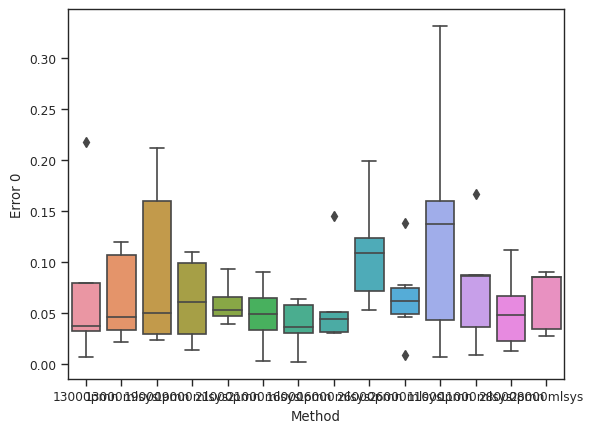

        method   error_0   error_1   error_2   error_3   error_4
0   11000mlsys  0.086858  0.057461  0.070157  0.063555  0.149962
1     11000pmn  0.137964  0.019830  0.091499  0.064419  0.051908
2   13000mlsys  0.046535  0.061349  0.041950  0.062098  0.113278
3     13000pmn  0.037009  0.017392  0.136141  0.057948  0.088570
4   16000mlsys  0.044599  0.042765  0.044466  0.054456  0.065331
5     16000pmn  0.035990  0.014396  0.057415  0.017454  0.013198
6   19000mlsys  0.060623  0.055756  0.055994  0.056863  0.116126
7     19000pmn  0.050298  0.015600  0.079636  0.018302  0.034599
8   21000mlsys  0.049549  0.094950  0.079707  0.100920  0.017312
9     21000pmn  0.053195  0.013146  0.053912  0.061049  0.030309
10  26000mlsys  0.061955  0.085752  0.036219  0.095154  0.136128
11    26000pmn  0.108621  0.101427  0.352444  0.123952  0.042761
12  28000mlsys  0.085386  0.106229  0.059114  0.039476  0.093744
13    28000pmn  0.048631  0.016676  0.090397  0.049787  0.039020


In [44]:
# ['max_load', 'cc', 'error_0',"error_1","error_2","error_3","error_4", window]
print(data_frame_k.shape)
sns.boxplot(data=data_frame_k, x='method', y='error_0')
plt.xlabel('Method')
plt.ylabel('Error 0')
plt.show()

# Group the DataFrame by the 'window' column and calculate the median for 'error_1' to 'error_4'
median_errors = data_frame_k.groupby('method')[['error_0','error_1', 'error_2', 'error_3', 'error_4']].median()

# Reset the index to make 'window' a regular column instead of an index
median_errors = median_errors.reset_index()

# Print the resulting DataFrame with the median values for each window
print(median_errors)

In [43]:
import pandas as pd

# Filter the DataFrame for max_load less than 50%
max_load_lt_50 = data_frame_k[data_frame_k['max_load'] < 0.50]

# Filter the DataFrame for max_load greater than or equal to 50%
max_load_ge_50 = data_frame_k[data_frame_k['max_load'] >= 0.50]

# Calculate the median for 'error_1' to 'error_4' for each 'window' within max_load<50%
median_errors_lt_50 = max_load_lt_50.groupby('method')[['error_0','error_1', 'error_2', 'error_3', 'error_4']].median()

# Calculate the median for 'error_1' to 'error_4' for each 'window' within max_load>=50%
median_errors_ge_50 = max_load_ge_50.groupby('method')[['error_0','error_1', 'error_2', 'error_3', 'error_4']].median()

# Reset the index to make 'window' a regular column instead of an index
median_errors_lt_50 = median_errors_lt_50.reset_index()
median_errors_ge_50 = median_errors_ge_50.reset_index()

# Print the resulting DataFrames with the median values for each 'window' for max_load<50% and max_load>=50%
print("Median for error_1 to error_4 when max_load < 50%:")
print(median_errors_lt_50)

print("\nMedian for error_1 to error_4 when max_load >= 50%:")
print(median_errors_ge_50)


Median for error_1 to error_4 when max_load < 50%:
        method   error_0   error_1   error_2   error_3   error_4
0   11000mlsys  0.061666  0.064454  0.080867  0.064874  0.097675
1     11000pmn  0.101905  0.011930  0.079062  0.076197  0.077171
2   13000mlsys  0.046535  0.061349  0.089965  0.062098  0.106426
3     13000pmn  0.032670  0.017392  0.066657  0.028003  0.039630
4   16000mlsys  0.047754  0.035993  0.060881  0.092250  0.095542
5     16000pmn  0.047000  0.015219  0.072682  0.020603  0.010953
6   19000mlsys  0.027145  0.054656  0.065439  0.046117  0.099006
7     19000pmn  0.025618  0.014823  0.033197  0.008539  0.030970
8   21000mlsys  0.043098  0.077059  0.049102  0.076270  0.020848
9     21000pmn  0.049589  0.005892  0.053436  0.047299  0.022338
10  26000mlsys  0.065534  0.106611  0.041472  0.093880  0.143708
11    26000pmn  0.097359  0.086762  0.334282  0.118090  0.043380
12  28000mlsys  0.085387  0.091954  0.055775  0.034562  0.130438
13    28000pmn  0.035673  0.011981  0.0

In [34]:
MTU=1000
BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]

n_size_bucket_list_output=len(bin_size_list)+1

# N_FLOW_THRESHOLD_LIST=[0, 1, 10, 20]
N_FLOW_THRESHOLD_LIST=[5]
NR_PATHS_SAMPLED=500
NR_INTEPOLATE=100
N_FLOWS=NR_PATHS_SAMPLED*NR_INTEPOLATE*4
N_FLOWS_PER_PATH=NR_INTEPOLATE*4
enable_sample_per_path=False
sample_per_path_str="_samp" if enable_sample_per_path else "_nosamp"
# mlsys_dir_list=["mlsys_bdp_bt10_l30"]
# mlsys_dir_list=["mlsys_0114_const_bt10"]
# mlsys_dir_list=["mlsys_final_reprod_v1"]
mlsys_dir_list=["mlsys-param_e267"]
# mlsys_dir_list=["mlsys_bt1_p100"]
legend_list=['ns3-param','pmn-m-param',"mlsys"]

with open(f"../spec/pmn_m.mix.json", 'r') as f:
    mixes=json.load(f)
n_samples=100000
for N_FLOW_THRESHOLD in N_FLOW_THRESHOLD_LIST:
    print("N_FLOW_THRESHOLD: ",N_FLOW_THRESHOLD)
    for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
        res_final=[]
        for worst_low_id in [137, 165]:
        # for worst_low_id in [172]:
            mix_dir = f'../data/{worst_low_id}'
            df_pmn_m = pd.read_csv(f'{mix_dir}/{legend_list[1]}/records.csv')
            
            n_freq_list=[]
            n_flow_list=[]
            sizes=df_pmn_m['size']
            
            # mix_dir = f'/data2/lichenni/data_10m/{worst_low_id}'
            path_idx=0
            while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
                with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
                    lines = file.readlines()
                    data=lines[0].strip().split(",")
                    n_freq=int(data[-1])
                    n_freq_list.append(n_freq)
                    
                    flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
                    size_list=[sizes[flowid] for flowid in flowid_list]
                    
                    n_links=len(data[0].split("|"))-1
                    tmp=np.digitize(size_list, bin_size_list)
                    # tmp=np.digitize(size_list, bin_size_dict[n_links])
                    # Count occurrences of each bin index
                    bin_counts = np.zeros(n_size_bucket_list_output)
                    for bin_idx in tmp:
                        bin_counts[bin_idx]+=1
                    n_flow_list.append(bin_counts)
                path_idx+=1
            assert sum(n_freq_list)==NR_PATHS_SAMPLED
            n_flow_list=np.array(n_flow_list)
            
            df_ns3 = pd.read_csv(f'{mix_dir}/{legend_list[0]}/records.csv')
            df_mlsys = [[] for _ in range(n_size_bucket_list_output)]
            
            sizes_ns3=np.array(df_ns3['size'])
            sizes_pmn=np.array(df_pmn_m['size'])
            bin_ns3=np.digitize(sizes_ns3, bin_size_list)
            bin_pmn=np.digitize(sizes_pmn, bin_size_list)
            
            with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
                lines = file.readlines()
            lines = lines[1:]
            for line_idx,line in enumerate(lines):
                data=line.strip().split(",")
                data = [float(value) for value in data]
                assert len(data) == NR_INTEPOLATE
                n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
                
                if enable_sample_per_path:
                    n_flow_tmp=n_flow_list[line_idx//n_size_bucket_list_output]
                    n_flow_tmp=np.where(n_flow_tmp >= N_FLOW_THRESHOLD, n_flow_tmp, 0)
                    
                    if np.sum(n_flow_tmp)==0:
                        continue
                    prop_tmp=n_flow_tmp/np.sum(n_flow_tmp)
                    
                    num_tmp=int(N_FLOWS_PER_PATH*prop_tmp[line_idx%n_size_bucket_list_output])
                    
                    data_sampled=np.random.choice(data,num_tmp,replace=True)
                    for _ in range(n_freq):
                        df_mlsys[line_idx%n_size_bucket_list_output].extend(data_sampled)
                else:
                    if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD:
                        for _ in range(n_freq):
                            df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
                
            sldn_ns3=df_ns3['slowdown']
            sldn_pmn_m=df_pmn_m['slowdown']
            res_tmp=[]
            for i in range(len(bin_size_list)+1):
                tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
                tmp_sldn_mlsys=np.array(df_mlsys[i])
                
                tmp_sldn_ns3_sampled=np.random.choice(tmp_sldn_ns3,n_samples,replace=True)
                tmp_sldn_mlsys_sampled=np.random.choice(tmp_sldn_mlsys,n_samples,replace=True)
                res_tmp.append([tmp_sldn_ns3_sampled,tmp_sldn_mlsys_sampled])
            res_final.append(res_tmp)

        res_final=np.array(res_final)
           

N_FLOW_THRESHOLD:  5


In [14]:
from textwrap import wrap
def plot_cdf(
    raw_data,
    file_name,
    linelabels,
    x_label,
    y_label="CDF",
    log_switch=False,
    rotate_xaxis=False,
    ylim_low=0,
    xlim=None,
    xlim_bottom=None,
    fontsize=15,
    legend_font=15,
    loc=2,
    title=None,
    enable_abs=False,
    group_size=1,
):
    _fontsize = fontsize
    fig = plt.figure(figsize=(5.2, 2.5))  # 2.5 inch for 1/3 double column width
    ax = fig.add_subplot(111)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # plt.axhline(0.99, color='k', linewidth=2, linestyle='--')
    
    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    if log_switch:
        ax.set_xscale("log")

    plt.ylabel(y_label, fontsize=_fontsize)
    plt.xlabel(x_label, fontsize=_fontsize)
    linelabels = ["\n".join(wrap(l, 30)) for l in linelabels]
    for i in range(len(raw_data)):
        data = raw_data[i]
        data = data[~np.isnan(data)]
        if len(data) == 0:
            continue
        if enable_abs:
            data = abs(data)
        # data=random.sample(data,min(1e6,len(data)))
        data_size = len(data)
        # data=list(filter(lambda score: 0<=score < std_val, data))
        # Set bins edges
        data_set = sorted(set(data))
        bins = np.append(data_set, data_set[-1] + 1)

        # Use the histogram function to bin the data
        counts, bin_edges = np.histogram(data, bins=bins, density=False)

        counts = counts.astype(float) / data_size

        # Find the cdf
        cdf = np.cumsum(counts)

        # Plot the cdf
        if i < len(linelabels):
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                label=linelabels[i],
                linewidth=2,
            )
        else:
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                linewidth=2,
            )

    legend_properties = {"size": legend_font}
    plt.legend(
        prop=legend_properties,
        frameon=False,
        loc=loc,
    )

    plt.ylim((ylim_low, 1))
    if xlim_bottom:
        plt.xlim(left=xlim_bottom)
    if xlim:
        plt.xlim(right=xlim)
    # plt.tight_layout()
    # plt.tight_layout(pad=0.5, w_pad=0.04, h_pad=0.01)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    # plt.grid(True)
    
    if rotate_xaxis:
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
    if title:
        plt.title(title, fontsize=_fontsize - 5)
    if file_name:
        plt.savefig(file_name, bbox_inches="tight", pad_inches=0)



(2, 4, 2, 100000)
6.675600270669286 6.9506164
10.603440952092525 12.278349
4.752717930054391 4.866502
7.958594570458366 7.913091
4.86000342316096 4.566683
6.213692051364784 6.302126
5.02725779357581 4.845683
7.1861021324077425 7.057213592999967


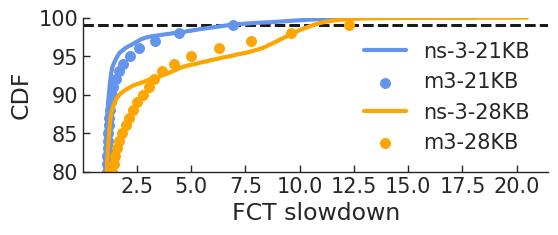

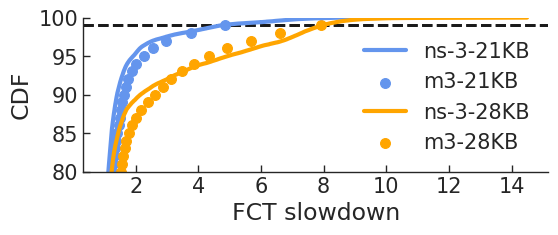

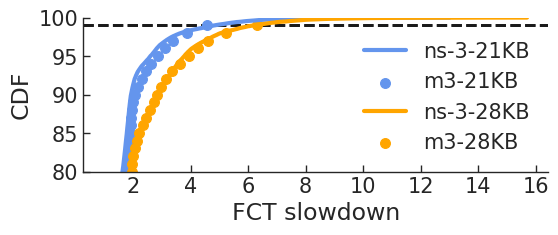

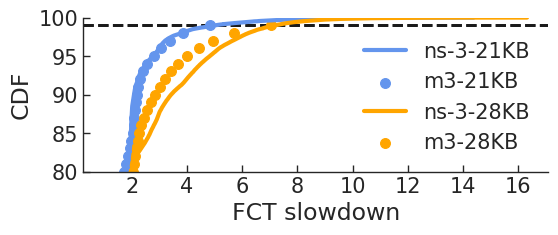

In [35]:
_fontsize=15
print(res_final.shape)
title_str_list=['-21KB','-28KB']
loc=4
P99_PERCENTILE_LIST=np.arange(1,100,1)
for i in range(res_final.shape[1]):
    data=res_final[:,i]
    
    fig = plt.figure(figsize=(6, 2))  # 2.5 inch for 1/3 double column width
    ax = fig.add_subplot(111)
    ax=plt.gca()
        
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")

    for idx,j in enumerate([0,1]):
        
        plt.plot(np.sort(data[j,0]), (np.arange(len(data[j,0]))/len(data[j,0])*100), label='ns-3'+title_str_list[j], color=color_list[idx], linewidth=3)
        sizebucket_to_sldn_flowsim=np.percentile(data[j,1],P99_PERCENTILE_LIST)
        plt.scatter(
            sizebucket_to_sldn_flowsim,
            P99_PERCENTILE_LIST,
            color=color_list[idx],
            label='m3'+title_str_list[j],
            marker="o",
            s=50,
        )
        print(f"{np.percentile(data[j,0],99)} {np.percentile(data[j,1],99)}")
        plt.axhline(99, color='k', linewidth=2, linestyle='--',zorder=0)
        legend_properties = {"size": _fontsize}
        plt.xlabel('FCT slowdown', fontsize=_fontsize+2)
        plt.ylabel('CDF', fontsize=_fontsize+2)
        plt.legend(prop=legend_properties,
        frameon=False,
        loc=loc)
        
        plt.ylim(80,100)
        plt.yticks(fontsize=_fontsize)
        plt.xticks(fontsize=_fontsize)
    plt.savefig(f'figs/eva_window_sldn_{i}.pdf', bbox_inches="tight", pad_inches=0)
    
            